## **EXP3 Predicting Missing Cell-Types from Bulks using Residuals**

*This file creates the file to run CIBERSORTx and BayesPrism deconvolution as stated in the parameters.*

Data downloaded from: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE176171
Original paper: https://pubmed.ncbi.nlm.nih.gov/35296864/ PMID: 35296864


**Summary:**
 Preprocessed data used to create multiple pseudobulk files in EXP3_pseudos.ipynb notebook. Here, we import those bulks and prepare files to be deconvolved with BayesPrism and CIBERSORTx. We can import pseudobulks with random proportions, with or without noise. Or, realsitic proportion pseudobulks with and without noise.

*This file can be run one kernel at a time, or all at once*

In [1]:
# import the dependencies
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
sys.path.insert(1, '../../../../../')

from functions import sn_sc_preprocess
from functions import validation_processing as vp
from importlib import reload
reload(sn_sc_preprocess)
reload(vp)
# general imports
import warnings
import numpy as np
from numpy import random
import pandas as pd
import scanpy as sc
from anndata import AnnData as ad
from tabulate import tabulate

import celltypist
from celltypist import models

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

import scipy as sp
from scipy.stats import spearmanr, pearsonr
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
import scipy.stats as stats
from scipy.spatial.distance import euclidean
from collections import Counter
import scipy as sp
from scipy.optimize import nnls
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import seaborn as sns
import umap
from sklearn.utils import resample
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# programming stuff
import time
import os, sys
import pickle
from pathlib import Path

In [2]:
#####################
### set the study ###
#####################

#Which deconv. method to prepare files for:
prep_cibersort = False
prep_bayesprism = True

#results paths:
res_name = "MCT_adp_EXP3"
pseudos_name = "MCT_adp_EXP3"
path = f"/../data/"
aug_data_path = "/../data/EXP3/"
data_path_cibersort = "/../data/EXP3/cibersort/"
data_path_bayesprism = "/../data/EXP3/BayesPrism/"
#noise_type 
nt = "noise" #[no noise, noise]
bulk_type = "realistic"  # [realistic, random]
random_seed = 88
bulks_type = f"{bulk_type}prop_{nt}"

#files get pretty big with all cell-types. 
#there's more than 24k cells in some cell-types.
#limit number if needed.
limit_celltypes = True
max_cells_per_type = 2000

## **Reading and QCing the data:**

In [3]:
actual_path = os.getcwd()
path = f"{actual_path}{path}"
aug_data_path = f"{actual_path}{aug_data_path}"
data_path_cibersort = f"{actual_path}{data_path_cibersort}"
data_path_bayesprism = f"{actual_path}{data_path_bayesprism}"

In [4]:
#single cell, missing 2 cell types
sc_adata_path = os.path.join(aug_data_path, f"{pseudos_name}_scadata_notlog.h5ad")
print(sc_adata_path)
sc_adata_path = Path(sc_adata_path)
sc_adata = sc.read_h5ad(sc_adata_path)
sc_adata

/projects/aivich@xsede.org/pred_missing_celltypes/preprocessing/../data/EXP3/MCT_adp_EXP3_scadata_notlog.h5ad


AnnData object with n_obs × n_vars = 18552 × 26672
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_types'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_var_genes'

In [5]:
#and its proportions
sc_prop = vp.make_prop_table(sc_adata, "cell_types")
sc_prop

,Cell_Types,Num_Cells,Prop_Cells
0,dendritic cell,983,0.052986
1,monocyte,636,0.034282
2,preadipocyte,13461,0.725582
3,endothelial cell of lymphatic vessel,157,0.008463
4,macrophage,1410,0.076003
5,T cell,807,0.043499
6,endothelial cell,542,0.029215
7,immature NK T cell,389,0.020968
8,B cell,36,0.001940
9,neutrophil,2,0.000108


In [6]:
#delete non-frequent cell-types:
sc_prop = sc_prop.drop(sc_prop[sc_prop['Cell_Types'] == 'B cell'].index)
sc_prop = sc_prop.drop(sc_prop[sc_prop['Cell_Types'] == 'neutrophil'].index)
sc_prop = sc_prop.drop(sc_prop[sc_prop['Cell_Types'] == 'smooth muscle cell'].index)
sc_prop = sc_prop.drop(sc_prop[sc_prop['Cell_Types'] == 'stromal cell of endometrium'].index)
sc_prop = sc_prop.drop(sc_prop[sc_prop['Cell_Types'] == 'Total'].index)
sc_prop

,Cell_Types,Num_Cells,Prop_Cells
0,dendritic cell,983,0.052986
1,monocyte,636,0.034282
2,preadipocyte,13461,0.725582
3,endothelial cell of lymphatic vessel,157,0.008463
4,macrophage,1410,0.076003
5,T cell,807,0.043499
6,endothelial cell,542,0.029215
7,immature NK T cell,389,0.020968
11,pericyte cell,52,0.002803
13,mast cell,53,0.002857


In [7]:
#single nucleus, missing 0 cell types
sn_adata_path = os.path.join(aug_data_path, f"{pseudos_name}_snadata_notlog.h5ad")
print(sn_adata_path)
sn_adata_path = Path(sn_adata_path)
sn_adata = sc.read_h5ad(sn_adata_path)
sn_adata

/projects/aivich@xsede.org/pred_missing_celltypes/preprocessing/../data/EXP3/MCT_adp_EXP3_snadata_notlog.h5ad


AnnData object with n_obs × n_vars = 116066 × 28242
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_types'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_var_genes'

In [8]:
#and its proportions
sn_prop = vp.make_prop_table(sn_adata, "cell_types")
sn_prop

,Cell_Types,Num_Cells,Prop_Cells
0,mesothelial cell,26276,0.226388
1,fat cell,24825,0.213887
2,macrophage,13625,0.117390
3,preadipocyte,26941,0.232118
4,endothelial cell,11480,0.098909
5,endothelial cell of lymphatic vessel,2339,0.020152
6,pericyte cell,1165,0.010037
7,T cell,3022,0.026037
8,smooth muscle cell,2457,0.021169
9,B cell,231,0.001990


In [9]:
#delete non-frequent cell-types:
sn_prop = sn_prop.drop(sn_prop[sn_prop['Cell_Types'] == 'B cell'].index)
sn_prop = sn_prop.drop(sn_prop[sn_prop['Cell_Types'] == 'neutrophil'].index)
sn_prop = sn_prop.drop(sn_prop[sn_prop['Cell_Types'] == 'smooth muscle cell'].index)
sn_prop = sn_prop.drop(sn_prop[sn_prop['Cell_Types'] == 'stromal cell of endometrium'].index)
sn_prop = sn_prop.drop(sn_prop[sn_prop['Cell_Types'] == 'Total'].index)
sn_prop

,Cell_Types,Num_Cells,Prop_Cells
0,mesothelial cell,26276,0.226388
1,fat cell,24825,0.213887
2,macrophage,13625,0.117390
3,preadipocyte,26941,0.232118
4,endothelial cell,11480,0.098909
5,endothelial cell of lymphatic vessel,2339,0.020152
6,pericyte cell,1165,0.010037
7,T cell,3022,0.026037
10,dendritic cell,679,0.005850
11,mast cell,883,0.007608


In [10]:
# Filter Anndata objects to only have frequent cell types
sn_adata = sn_adata[sn_adata.obs['cell_types'].isin(sn_prop['Cell_Types'])]
sc_adata = sc_adata[sc_adata.obs['cell_types'].isin(sc_prop['Cell_Types'])]

# Display the resulting filtered Anndata objects
print(sn_adata)
print(sc_adata)

View of AnnData object with n_obs × n_vars = 113017 × 28242
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_types'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_var_genes'
View of AnnData object with n_obs × n_vars = 18490 × 26672
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_types'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_var_genes'


QC imported dataset:

In [11]:
#QC that it is not normalized
sc_adata.X.max()

1558.0

         Falling back to preprocessing with `sc.pp.pca` and default params.


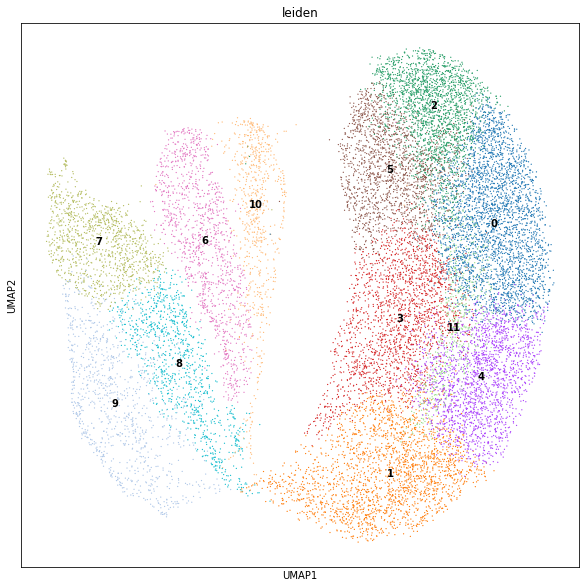

In [12]:
# lets use Leiden clustering
sc.pp.neighbors(sc_adata)
sc.tl.umap(sc_adata)
sc.tl.leiden(sc_adata, resolution=0.8)
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(sc_adata, color='leiden', legend_loc='on data')

In [13]:
Counter(sc_adata.obs["cell_types"])

Counter({'dendritic cell': 983,
         'monocyte': 636,
         'preadipocyte': 13461,
         'endothelial cell of lymphatic vessel': 157,
         'macrophage': 1410,
         'T cell': 807,
         'endothelial cell': 542,
         'immature NK T cell': 389,
         'pericyte cell': 52,
         'mast cell': 53})

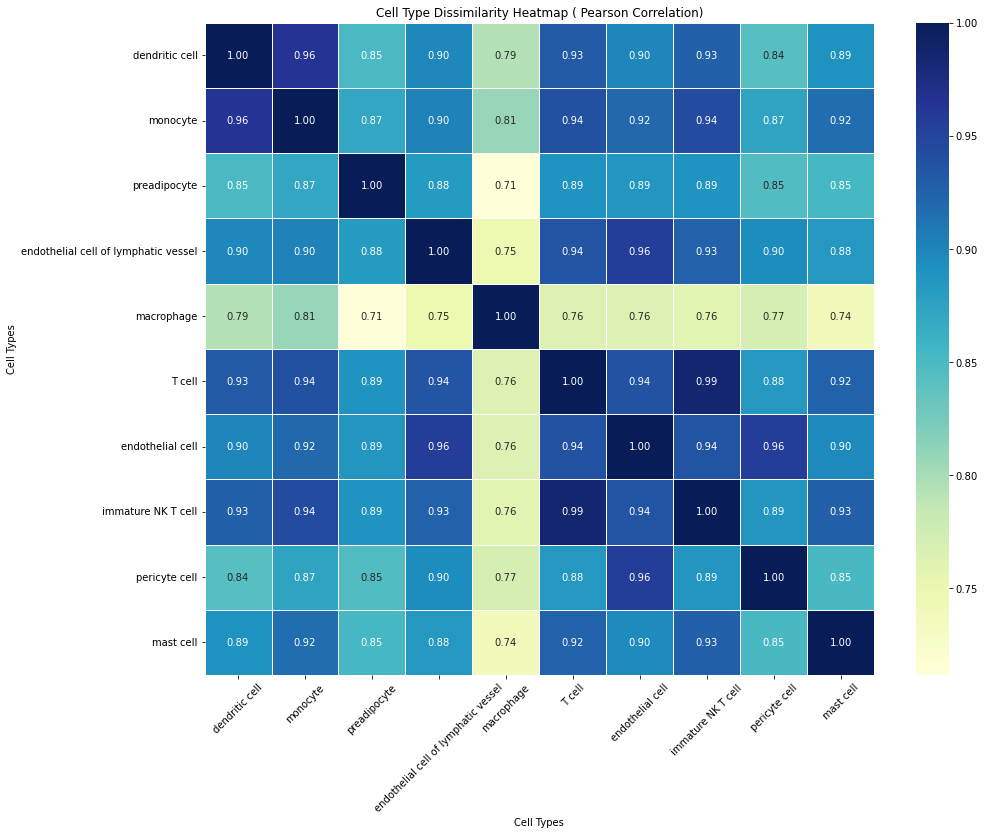

In [14]:
# Define the number of samples for resampling
num_samples = 10000

# Making cell type reference without scaling
cell_types = sc_adata.obs["cell_types"].unique()
gene_ids = sc_adata.var["gene_ids"]
ref_raw = pd.DataFrame(index=gene_ids, columns=cell_types)

for cell_type in cell_types:
    cell_df = sc_adata[sc_adata.obs["cell_types"].isin([cell_type])]
    cell_sample = resample(cell_df, n_samples=num_samples, replace=True)
    x = cell_sample.X.sum(axis=0)
    sum_over_genes = pd.DataFrame(x).T
    ref_raw[cell_type] = sum_over_genes.values

# Calculate Pearson correlations
correlation_matrix = ref_raw.corr()

# Create a DataFrame for the similarity matrix
cell_types_similarity =correlation_matrix  # Convert correlations to dissimilarities
similarity_df = pd.DataFrame(cell_types_similarity, columns=cell_types, index=cell_types)

# Create a heatmap to visualize the similarities
plt.figure(figsize=(15, 12))
sns.heatmap(similarity_df, cmap="YlGnBu", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Cell Type Dissimilarity Heatmap ( Pearson Correlation)")
plt.xlabel("Cell Types")
plt.ylabel("Cell Types")
plt.xticks(rotation=45)
plt.show()

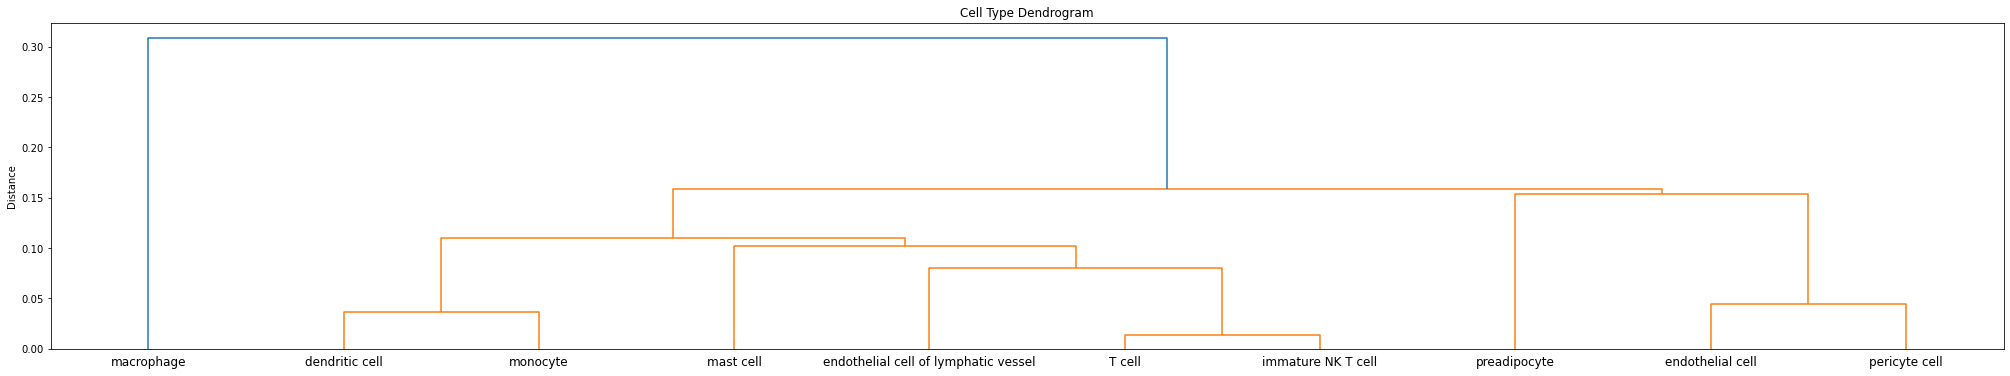

In [15]:
# Calculate Pearson correlations
correlation_matrix = ref_raw.corr()

# Create a DataFrame for the similarity matrix
cell_types_similarity =1 - correlation_matrix  # Convert correlations to dissimilarities
similarity_df = pd.DataFrame(cell_types_similarity, columns=cell_types, index=cell_types)

# Create a dendrogram to visualize hierarchical clustering
linkage_matrix = linkage(squareform(cell_types_similarity), method='ward')
plt.figure(figsize=(35, 6))
dendrogram(linkage_matrix, labels=cell_types, orientation='top')
plt.title("Cell Type Dendrogram")
plt.ylabel("Distance")
plt.show()

In [16]:
#adding obs to match functions
sc_adata.obs["scpred_CellType"] = sc_adata.obs["cell_types"]

Cell Types are already missing from reference, so importing Pseudobulks

## **Importing and QCing Pseudobulks**

In [17]:
#using SN because that's the data from which the pseudobulks were created
num_cell_type_specific = 50 * int(sn_adata.obs["cell_types"].unique().shape[0])
num_bulks = 200+num_cell_type_specific+200+200
num_bulks

1200

In [18]:
X_full, Y_full, gene_df, meta_df= sn_sc_preprocess.read_all_pseudobulk_files(data_path=aug_data_path, noise_type=f"{nt}_", file_name = pseudos_name, num_bulks_training = num_bulks, num_files=10, random_selection = False)
X_full.index = meta_df.index
Y_full.index = meta_df.index

0
1
2
3
4
5
6
7
8
9


(8000, 2)
(8000, 2)


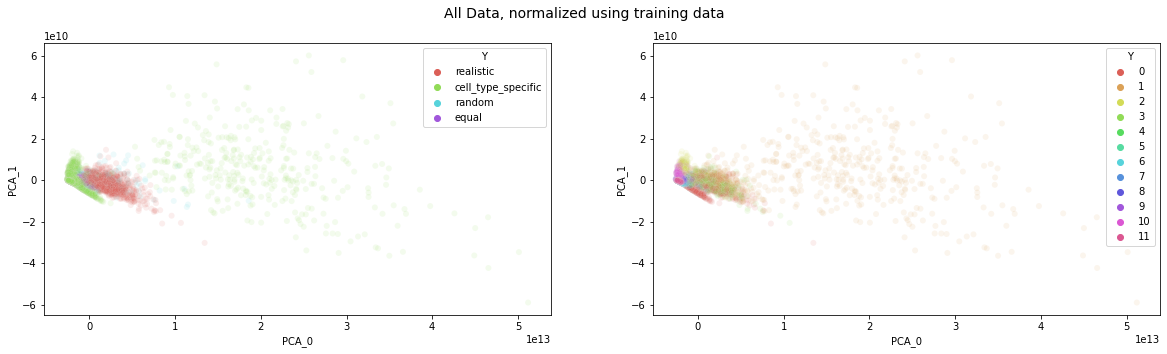

In [19]:
## plot samples (some of them for speed)
X_temp = X_full.iloc[0:8000]
Y_temp_p = Y_full.iloc[0:8000]
meta_temp = meta_df.iloc[0:8000]

plot_df = vp.get_pca_for_plotting(X_temp)

fig, axs = plt.subplots(1, 2, figsize=(20,5))

Y_temp = np.copy(Y_temp_p)
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_pca(plot_df, meta_temp.cell_prop_type.to_numpy(), axs[0], title=f"")
vp.plot_pca(plot_df, Y_temp, axs[1], title=f"")

fig.suptitle("All Data, normalized using training data", fontsize=14)

fig.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8000 samples in 0.131s...
[t-SNE] Computed neighbors for 8000 samples in 2.687s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8000
[t-SNE] Computed conditional probabilities for sample 2000 / 8000
[t-SNE] Computed conditional probabilities for sample 3000 / 8000
[t-SNE] Computed conditional probabilities for sample 4000 / 8000
[t-SNE] Computed conditional probabilities for sample 5000 / 8000
[t-SNE] Computed conditional probabilities for sample 6000 / 8000
[t-SNE] Computed conditional probabilities for sample 7000 / 8000
[t-SNE] Computed conditional probabilities for sample 8000 / 8000
[t-SNE] Mean sigma: 5038359616.131983
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.226147
[t-SNE] KL divergence after 500 iterations: 0.669077
(8000, 2)
(8000, 2)


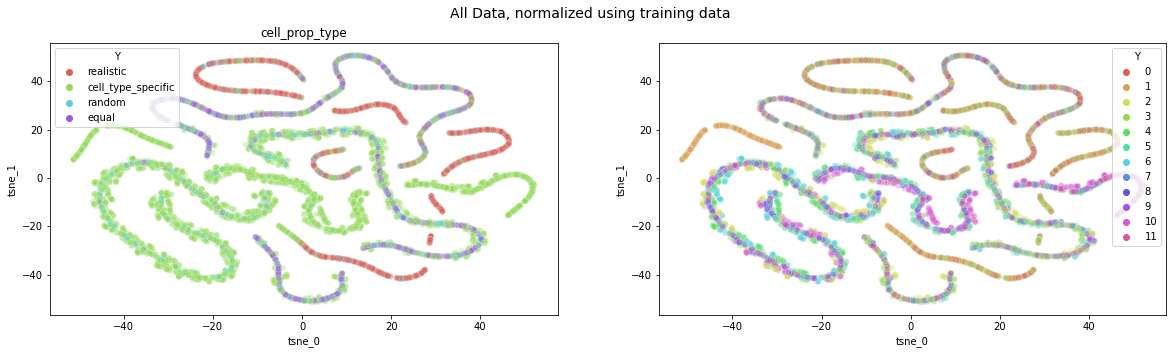

In [20]:
## plot samples (some of them for speed)
X_temp = X_full.iloc[0:8000]
Y_temp_p = Y_full.iloc[0:8000]
meta_temp = meta_df.iloc[0:8000]

plot_df = vp.get_tsne_for_plotting(X_temp)

fig, axs = plt.subplots(1, 2, figsize=(20,5))

Y_temp = np.copy(Y_temp_p)
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_tsne(plot_df, meta_temp.cell_prop_type.to_numpy(), axs[0], title=f"cell_prop_type")
vp.plot_tsne(plot_df, Y_temp, axs[1], title=f"")

fig.suptitle("All Data, normalized using training data", fontsize=14)
fig.show()

In [21]:
#cut to only the samples mentioned above in bulk_type var
idx_interest = np.where(meta_df.cell_prop_type == bulk_type)[0]
pseudos_df = X_full.iloc[idx_interest]
prop_df = Y_full.iloc[idx_interest]
pseudos_df.index = range(0,len(pseudos_df))
prop_df.index = pseudos_df.index
meta_df.index = meta_df.index
pseudos_df

gene_ids,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A3GALT2,A4GALT,A4GNT,...,AP003550.1,AC005544.2,AC025674.2,AC105924.1,AC239803.3,AL049555.1,AL109945.1,HIST1H3G,PAEP,PLA2G1B
0,1135.576532,10622.841759,147.975433,7.256896e+06,8882.201212,2453.162734,364798.169087,161.941860,34552.752808,4.021850,...,0.850758,0.0,0.855445,3.327791,0.859750,0.0,0.0,0.000000,2.045688,0.000000
1,1301.547512,5777.053490,446.339573,2.150736e+06,5473.369174,1700.935950,542306.550651,109.178226,38012.931024,238.565399,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,4.594980,0.000000
2,2536.894521,16215.397426,100.321835,6.381928e+06,15323.842579,5759.959194,484818.858708,127.410838,53256.256344,103.856615,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
3,2396.312515,9066.405497,412.753621,4.101817e+06,15788.186599,3171.974142,515476.913826,277.063003,32106.713358,235.658194,...,0.000000,0.0,0.000000,18.327299,0.000000,0.0,0.0,1.950714,8.597643,0.000000
4,3989.739734,37209.672341,299.898163,1.840197e+07,55434.284019,2864.426610,627315.076648,207.985944,41219.341601,31.015966,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.069885,19.484225,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,3333.840868,17682.026136,37.037602,1.538425e+07,11586.794342,3969.068614,397298.945742,113.516212,64829.130442,43.621312,...,3.358132,0.0,0.000000,2.450848,0.000000,0.0,0.0,0.000000,0.936557,0.989762
1996,4611.341502,28630.318446,280.074538,1.581100e+07,21577.398018,3992.451081,685068.165358,264.163759,121374.929179,109.278061,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,7.391111,2.342282,0.000000
1997,770.464211,17182.205114,738.123426,9.687488e+06,13995.789438,2443.271150,419395.539480,74.861656,43519.367304,32.515328,...,0.838176,0.0,0.000000,0.000000,0.942274,0.0,0.0,0.000000,4.139641,1.895742
1998,2429.285058,23314.562079,498.789215,1.278696e+07,19102.751300,3297.830037,999619.492129,338.849664,55365.046590,57.215134,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000


In [22]:
#cutting to 1000 pseudos w/ random seed
random.seed(seed=random_seed)
idx_to_keep = np.random.choice(pseudos_df.index, 1000, replace=False)
#cutting both props and pseudos
pseudos_df = pseudos_df.iloc[idx_to_keep]
prop_df = prop_df.iloc[idx_to_keep]
pseudos_df

gene_ids,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A3GALT2,A4GALT,A4GNT,...,AP003550.1,AC005544.2,AC025674.2,AC105924.1,AC239803.3,AL049555.1,AL109945.1,HIST1H3G,PAEP,PLA2G1B
1059,2520.366951,11670.552062,315.683682,1.264329e+07,24330.841577,5194.477533,5.864209e+05,183.523511,56549.460392,6.415051,...,0.000000,0.0,0.000000,11.931349,0.000000,0.000000,0.000000,0.000000,6.520295,0.000000
929,2652.030884,16177.960357,74.508861,9.194966e+06,9155.510763,7152.173561,5.875589e+05,752.989609,127282.373996,5.614204,...,0.000000,0.0,0.000000,0.000000,0.000000,1.044804,0.000000,0.000000,0.000000,1.205524
1506,2209.866112,15388.949112,256.622931,5.897827e+06,6843.874419,4502.988497,6.784570e+05,309.143584,91665.127709,21.209507,...,0.000000,0.0,2.588109,21.406332,0.000000,0.000000,0.000000,0.953906,0.890686,0.000000
237,5470.956467,10004.801201,352.795385,8.302851e+06,21620.753308,3937.204668,1.025719e+06,186.522370,63847.225962,106.919565,...,0.000000,0.0,0.000000,2.367033,0.000000,3.710758,0.000000,0.000000,0.000000,0.000000
1371,1846.186054,8484.225187,226.027663,8.406016e+06,9783.506418,5590.378028,6.113888e+05,556.066521,49192.053054,36.932117,...,0.000000,0.0,0.000000,6.460765,1.013585,0.000000,0.000000,0.000000,1.884949,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1573,1375.897818,8124.305578,263.245947,3.914193e+06,13874.978016,7439.165119,5.809178e+05,271.123691,46238.988026,314.430676,...,0.000000,0.0,0.000000,1.052183,2.713263,0.000000,0.000000,2.134911,4.712430,0.000000
1132,2327.872255,17643.877623,97.551079,5.311424e+06,11901.354024,1144.777780,5.263940e+05,86.195673,21914.480500,66.347441,...,0.892992,0.0,0.000000,0.000000,0.000000,0.000000,2.582810,0.000000,13.113886,0.736567
1998,2429.285058,23314.562079,498.789215,1.278696e+07,19102.751300,3297.830037,9.996195e+05,338.849664,55365.046590,57.215134,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1988,1709.627757,12551.240523,49.685061,5.898732e+06,5982.073699,2691.849242,3.117385e+05,133.598166,79254.252811,77.740887,...,0.000000,0.0,0.892384,5.533190,0.000000,0.992998,0.955007,0.000000,8.404917,0.000000


## **Putting together all reference expression and proportions.**

### **Single cell (missing 2):**

In [23]:
#cell order are the columns in the proportions 
cell_order = prop_df.columns
#missing 2
num = 2

In [24]:
#import anndata object
adata_path = os.path.join(aug_data_path, f"{pseudos_name}_scadata_notlog.h5ad")
adata_path = Path(adata_path)
adata = sc.read_h5ad(adata_path)
# Filter Anndata objects to only have frequent cell types
adata = adata[adata.obs['cell_types'].isin(sn_prop['Cell_Types'])]
adata.obs["cell_types"].unique()

['dendritic cell', 'monocyte', 'preadipocyte', 'endothelial cell of lymphatic vessel', 'macrophage', 'T cell', 'endothelial cell', 'immature NK T cell', 'pericyte cell', 'mast cell']
Categories (10, object): ['T cell', 'dendritic cell', 'endothelial cell', 'endothelial cell of lymphatic vessel', ..., 'mast cell', 'monocyte', 'pericyte cell', 'preadipocyte']

In [25]:
if limit_celltypes:
    #import anndata object
    adata_path = os.path.join(aug_data_path, f"{pseudos_name}_scadata_notlog.h5ad")
    adata_path = Path(adata_path)
    adata = sc.read_h5ad(adata_path)
    # Filter Anndata objects to only have frequent cell types
    adata = adata[adata.obs['cell_types'].isin(sn_prop['Cell_Types'])]
    print(adata.obs["cell_types"].unique())
    
    cell_types_to_limit = cell_order
    #define the cell types to limit and the desired maximum number of cells
    max_cells_per_type = max_cells_per_type

    #dreate a mask to identify cells from the cell types to limit
    mask_to_limit = adata.obs["cell_types"].isin(cell_types_to_limit)

    #create a mask for the remaining cell types
    mask_remaining = ~mask_to_limit

    #initialize a dictionary to keep track of removed cells per cell type
    removed_cells_count = {cell_type: 0 for cell_type in cell_types_to_limit}

    #initialize arrays to store new observations and filtered indices
    new_obs = []
    filtered_indices = []

    #iterate through each cell in the original sn_adata object
    for cell_idx, cell_type in enumerate(adata.obs["cell_types"]):
        if cell_type in cell_types_to_limit:
            removed_count = removed_cells_count.get(cell_type, 0)
            if removed_count < max_cells_per_type:
                removed_cells_count[cell_type] = removed_count + 1
                filtered_indices.append(cell_idx)

    #create a new AnnData object with the filtered cells
    filtered_sc_adata = sc.AnnData(
        X=adata.X[filtered_indices],
        obs=adata.obs.iloc[filtered_indices],
        var=adata.var
    )

    #cppend the remaining cell types to the filtered sn_adata object
    filtered_sc_adata = filtered_sc_adata.concatenate(
        adata[mask_remaining],
        join="outer"
    )
    #QC
    print(Counter(filtered_sc_adata.obs.cell_types))
    #save as anndata object
    adata_path = os.path.join(aug_data_path, f"{pseudos_name}_scadata_limitedcells_notlog.h5ad")
    adata_path = Path(adata_path)
    filtered_sc_adata.write_h5ad(adata_path)

    #with no cell missing is just the anndata object as is, but if you limit cell types:
    #import anndata object
    adata_path = os.path.join(aug_data_path, f"{pseudos_name}_scadata_limitedcells_notlog.h5ad")
    adata_path = Path(adata_path)
    sc_adata = sc.read_h5ad(adata_path)
else:
    #with no cell missing is just the anndata object as is, but if you limit cell types:
    #import anndata object
    adata_path = os.path.join(aug_data_path, f"{pseudos_name}_scadata_notlog.h5ad")
    adata_path = Path(adata_path)
    sc_adata = sc.read_h5ad(adata_path)
    # Filter Anndata objects to only have frequent cell types
    sc_adata = sc_adata[sc_adata.obs['cell_types'].isin(sc_prop['Cell_Types'])]
sc_adata

... storing 'cell_types' as categorical


['dendritic cell', 'monocyte', 'preadipocyte', 'endothelial cell of lymphatic vessel', 'macrophage', 'T cell', 'endothelial cell', 'immature NK T cell', 'pericyte cell', 'mast cell']
Categories (10, object): ['T cell', 'dendritic cell', 'endothelial cell', 'endothelial cell of lymphatic vessel', ..., 'mast cell', 'monocyte', 'pericyte cell', 'preadipocyte']
Counter({'preadipocyte': 2000, 'macrophage': 1410, 'dendritic cell': 983, 'T cell': 807, 'monocyte': 636, 'endothelial cell': 542, 'immature NK T cell': 389, 'endothelial cell of lymphatic vessel': 157, 'mast cell': 53, 'pericyte cell': 52})


AnnData object with n_obs × n_vars = 7029 × 26672
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_types', 'batch'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_var_genes'

In [26]:
#dense matrix is the adata's expression
dense_matrix = sc_adata.X.todense()

dense_df = pd.DataFrame(dense_matrix, columns = sc_adata.var['gene_ids'])
dense_df.insert(loc=0, column='cell_types', value=sc_adata.obs["cell_types"].to_list())

In [27]:
sc_cell_types = vp.make_prop_table(sc_adata, "cell_types")
sc_cell_types = sc_cell_types.drop(axis=0, index = len(sc_cell_types)-1)
sc_cell_types = sc_cell_types.sort_values('Cell_Types')
sc_cell_types = sc_cell_types.reindex()
sc_cell_types

,Cell_Types,Num_Cells,Prop_Cells
5,T cell,807,0.114810
0,dendritic cell,983,0.139849
6,endothelial cell,542,0.077109
3,endothelial cell of lymphatic vessel,157,0.022336
7,immature NK T cell,389,0.055342
4,macrophage,1410,0.200598
9,mast cell,53,0.007540
1,monocyte,636,0.090482
8,pericyte cell,52,0.007398
2,preadipocyte,2000,0.284535


In [28]:
sn_cell_types = vp.make_prop_table(sn_adata, "cell_types")
sn_cell_types = sn_cell_types.drop(axis=0, index = len(sn_cell_types)-1)
sn_cell_types = sn_cell_types.sort_values('Cell_Types')
sn_cell_types = sn_cell_types.reindex()
sn_cell_types

,Cell_Types,Num_Cells,Prop_Cells
7,T cell,3022,0.026739
8,dendritic cell,679,0.006008
4,endothelial cell,11480,0.101578
5,endothelial cell of lymphatic vessel,2339,0.020696
1,fat cell,24825,0.219657
11,immature NK T cell,1073,0.009494
2,macrophage,13625,0.120557
9,mast cell,883,0.007813
0,mesothelial cell,26276,0.232496
10,monocyte,709,0.006273


In [29]:
#matching proportion in reference (made from SC cells) to SN proportions
#we want the expression in the reference to be SC proportions with SN expression.
new_dense = pd.DataFrame(columns=dense_df.columns)
#for each cell type in SN
for cell_type in sn_cell_types["Cell_Types"]:
    #get its indexes in SN
    idx_in_mat = sn_cell_types[sn_cell_types['Cell_Types'] == str(cell_type)].index[0]
    # get its indexes in SC
    all_cells_from_type = dense_df[dense_df["cell_types"] == cell_type].index
    #how many there are in SN
    size = sn_cell_types['Num_Cells'].loc[idx_in_mat]
    #limiting celltypes
    if size > max_cells_per_type:
        size = max_cells_per_type
    #and sample that cell, with replacement if you're out of new SC cells.    
    if all_cells_from_type.shape != (0,):  
        if len(all_cells_from_type) < size:
            rep = True
        else:
            rep = False    
        random_idx = np.random.choice(all_cells_from_type, size=size, replace=rep)
        old_dense = dense_df.loc[random_idx]
        new_dense = pd.concat([new_dense, old_dense])
new_dense

gene_ids,cell_types,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A3GALT2,A4GALT,...,ULBP1,WTH3DI,XIRP1,Z82196.2,Z84488.1,Z99755.2,Z99916.3,ZNF280A,ZPBP2,CD99.Y
3658,T cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4146,T cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3917,T cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4816,T cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6778,T cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1816,preadipocyte,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2859,preadipocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1875,preadipocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2047,preadipocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
#now this is the adapted SC (missing 2) dataframe.
dense_df = new_dense.sort_index()
dense_df_copy = dense_df.copy()
dense_df

gene_ids,cell_types,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A3GALT2,A4GALT,...,ULBP1,WTH3DI,XIRP1,Z82196.2,Z84488.1,Z99755.2,Z99916.3,ZNF280A,ZPBP2,CD99.Y
1,monocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,monocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,monocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,preadipocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,endothelial cell of lymphatic vessel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7026,immature NK T cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7026,immature NK T cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7026,immature NK T cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7027,T cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


For CIBERSORTx:

In [31]:
if prep_cibersort:
    #now this is the adapted SC (missing 2) dataframe.
    new_dense_ciber = new_dense.copy()
    dense_df_ciber = new_dense.sort_index()
    dense_df_ciber

In [32]:
if prep_cibersort:
    #qc
    dense_df_ciber.index = dense_df_ciber["cell_types"]
    #does not have the cell types from SN
    print(Counter(dense_df_ciber["cell_types"]))
    dense_df_ciber.pop("cell_types")
    sig_df_sn_ciber = dense_df_ciber

In [33]:
if prep_cibersort:
    #details
    exp_id_ciber = f"{res_name}"
    patient_idx_ciber = f"{bulk_type}"
    #and create files for CIBERSORTX
    mix_ciber, sig_ciber = sn_sc_preprocess.write_cibersortx_files(bp_path = data_path_cibersort, out_file_id = exp_id_ciber, 
                            sig_df= sig_df_sn_ciber, X_train = pseudos_df, num_str = '2', bulks_type = bulks_type)

Now for BayesPrism:

In [34]:
if prep_bayesprism: 
  cell_states = dict()
  all_refs = dict()
  cols = ["cell_id", "cell_type", "cell_subtype", "tumor_state"] #for cell state
  dense_df_bayes = dense_df.copy()

In [35]:
if prep_bayesprism:
    #now creating the cell state file
    # cell_id, cell_type, cell_subtype and tumor_state
    num= 2
    cell_state = pd.DataFrame(columns = cols)
    cell_state["cell_type"] = dense_df_bayes["cell_types"].to_list()
    cell_state["cell_id"] = range(1,len(cell_state["cell_type"])+ 1 ) #+1 for R
    cell_state["cell_subtype"] = dense_df_bayes["cell_types"].to_list()
    cell_state["tumor_state"] = 0
    cell_states[num] = cell_state

    cellstate_path = os.path.join(data_path_bayesprism, f"{res_name}_{bulks_type}_{num}missing_cellstate.csv")
    cellstate_path = Path(cellstate_path)
    cell_states[num].to_csv(cellstate_path, index = False)
    
    #dropping cell types, they're now in cell state
    dense_df_bayes.pop("cell_types")

    #qc
    print(dense_df_bayes.shape)
    print(cell_state.shape)
    dense_df_bayes.columns = dense_df_bayes.columns.values
    #saving as the reference
    all_refs[num] = dense_df_bayes
    dense_df_bayes
cell_state["cell_type"].unique()

(14509, 26672)
(14509, 4)


array(['monocyte', 'preadipocyte', 'endothelial cell of lymphatic vessel',
       'T cell', 'dendritic cell', 'macrophage', 'endothelial cell',
       'immature NK T cell', 'pericyte cell', 'mast cell'], dtype=object)

In [36]:
if prep_bayesprism:
    mix = dict()
    sig = dict()
    num = 2
    reference = all_refs[num]
    reference.index = range(1, len(reference)+1)
    #details
    num_str = str(num)  
    exp_id = str(res_name)
    #and create files for EXP3 BP
    mix[num], sig[num] = sn_sc_preprocess.write_bp_files(bp_path = data_path_bayesprism, out_file_id = res_name, 
                                            sig_df = reference,  X_train = pseudos_df, num_str = num_str, bulks_type= bulks_type)

### **Mixture (pseudobulks) and Proportions:**

For BayesPrism:

In [37]:
if prep_bayesprism:
    # initializing dicitonaries of proportions and cell references.
    all_prop_refs_rebalanced = dict()
    all_prop_refs = dict()

    #matching R index
    dense_df_bayes.index = dense_df_bayes.index +  1
    #qc
    sig_df_sn_bayes = dense_df_bayes
    print(sig_df_sn_bayes.shape)
    #num is 2, 2 missing cell types.
    all_refs[num] = sig_df_sn_bayes

(14509, 26672)


In [38]:
if prep_bayesprism:
    prop_df_copy = prop_df.copy()
    #dropping cell types missing from proportions
    cells_to_miss = np.setdiff1d(sn_cell_types["Cell_Types"], sc_cell_types["Cell_Types"])
    all_prop_refs_rebalanced[2] = prop_df_copy.drop(cells_to_miss, axis=1) 
    all_prop_refs[2] = prop_df_copy.drop(cells_to_miss, axis=1)
# for rebalancing proportions in analysis
all_prop_refs_rebalanced[2]    

,macrophage,preadipocyte,endothelial cell,endothelial cell of lymphatic vessel,pericyte cell,T cell,dendritic cell,mast cell,monocyte,immature NK T cell
1059,0.071567,0.245863,0.120525,0.019584,0.00759,0.074458,0.00535,0.01039,0.001897,0.003906
929,0.085881,0.314789,0.105636,0.012583,0.001215,0.027419,0.008544,0.007408,0.002831,0.028284
1506,0.085022,0.250095,0.079147,0.013616,0.001362,0.047323,0.006731,0.002357,0.002784,0.006687
237,0.088081,0.206959,0.141107,0.015814,0.003161,0.034946,0.002017,0.006457,0.009805,0.015593
1371,0.127004,0.215653,0.131966,0.017662,0.008908,0.012639,0.013212,0.008211,0.003316,0.002831
...,...,...,...,...,...,...,...,...,...,...
1573,0.067966,0.347107,0.042189,0.014701,0.006889,0.014713,0.001712,0.008952,0.001058,0.007628
1132,0.104532,0.195488,0.056302,0.013258,0.004893,0.023814,0.005609,0.003333,0.000618,0.034899
1998,0.13956,0.173742,0.113052,0.008985,0.01009,0.041297,0.001283,0.008843,0.001505,0.022237
1988,0.07255,0.281459,0.106864,0.015946,0.030261,0.037821,0.002904,0.000647,0.00753,0.0037


In [39]:
if prep_bayesprism:
    #missing no cells (just the proportions)
    # this is just the proportions as they are.
    all_prop_refs[0] = prop_df 
    all_prop_refs_rebalanced[0] = prop_df

In [40]:
if prep_bayesprism:
    #and save files
    # to rebalance proportions later
    sc_profile_file_ = os.path.join(data_path_bayesprism, f"{res_name}_{bulks_type}_proprebal.csv")
    sc_profile_path_ = Path(sc_profile_file_)
    all_prop_refs_rebalanced[num].to_csv(sc_profile_path_, index=False)
    #and not rebalances
    sc_profile_file = os.path.join(data_path_bayesprism, f"{res_name}_{bulks_type}_prop.csv")
    sc_profile_path = Path(sc_profile_file)
    all_prop_refs[num].to_csv(sc_profile_path, index=False)

In [41]:
if prep_bayesprism:
    sc_profile_file = os.path.join(data_path_bayesprism, f"{res_name}_{bulks_type}_mixture.csv")
    sc_profile_path = Path(sc_profile_file)
    mix[2].to_csv(sc_profile_path, index= True)
mix[2]

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
gene_ids,,,,,,,,,,,,,,,,,,,,,
A1BG,2.520367e+03,2.652031e+03,2.209866e+03,5.470956e+03,1.846186e+03,3.590721e+03,2.934251e+03,2.401252e+03,1.936010e+03,3.658875e+03,...,1.523201e+03,2.056857e+03,2.690369e+03,2.878466e+03,2.233627e+03,1.375898e+03,2.327872e+03,2.429285e+03,1.709628e+03,1.738499e+03
A1BG-AS1,1.167055e+04,1.617796e+04,1.538895e+04,1.000480e+04,8.484225e+03,1.777554e+04,9.791417e+03,1.983371e+04,1.301185e+04,1.917408e+04,...,8.905584e+03,1.103914e+04,1.536940e+04,2.026948e+04,1.847523e+04,8.124306e+03,1.764388e+04,2.331456e+04,1.255124e+04,1.009168e+04
A1CF,3.156837e+02,7.450886e+01,2.566229e+02,3.527954e+02,2.260277e+02,2.071427e+02,2.370561e+02,2.975902e+02,2.168870e+02,2.339708e+02,...,1.590535e+01,2.369594e+01,6.144500e+01,3.290311e+02,4.464403e+01,2.632459e+02,9.755108e+01,4.987892e+02,4.968506e+01,6.015793e+02
A2M,1.264329e+07,9.194966e+06,5.897827e+06,8.302851e+06,8.406016e+06,9.188202e+06,3.204401e+06,6.824850e+06,5.317383e+06,6.739135e+06,...,3.725101e+06,5.595848e+06,6.765217e+06,4.402084e+06,1.309498e+07,3.914193e+06,5.311424e+06,1.278696e+07,5.898732e+06,1.102936e+07
A2M-AS1,2.433084e+04,9.155511e+03,6.843874e+03,2.162075e+04,9.783506e+03,5.800927e+03,4.810931e+03,4.167848e+03,5.681772e+03,1.238615e+04,...,1.022332e+04,9.834868e+03,9.980004e+03,1.148239e+04,1.209588e+04,1.387498e+04,1.190135e+04,1.910275e+04,5.982074e+03,9.914499e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AL049555.1,0.000000e+00,1.044804e+00,0.000000e+00,3.710758e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.937756e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.037319e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.929982e-01,6.105576e+00
AL109945.1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.582810e+00,0.000000e+00,9.550066e-01,0.000000e+00
HIST1H3G,0.000000e+00,0.000000e+00,9.539059e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,9.293687e-01,5.392451e+00,0.000000e+00,0.000000e+00,1.029516e+00,2.134911e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


for CIBERSORTx:

In [42]:
if prep_cibersort:
    # mix contains all pseudobulks
    #details
    sc_profile_file = os.path.join(data_path_cibersort, f"{exp_id_ciber}_{bulks_type}_mixture.txt")
    sc_profile_path = Path(sc_profile_file)
    mix_ciber.to_csv(sc_profile_path, sep = '\t', index= True)

In [43]:
if prep_cibersort:
    #and proportions
    #mix contains all pseudobulks
    prop_profile_file = os.path.join(data_path_cibersort, f"{exp_id_ciber}_{bulks_type}_prop.txt")
    prop_profile_path = Path(prop_profile_file)
    prop_df.to_csv(prop_profile_path, sep = '\t', index= True)

### **Single nucleus (0 missing):**

In [44]:
num = 0

In [45]:
if limit_celltypes:
    adata_path = os.path.join(aug_data_path, f"{pseudos_name}_snadata_notlog.h5ad")
    adata_path = Path(adata_path)
    adata = sc.read_h5ad(adata_path)
    # Filter Anndata objects to only have frequent cell types
    adata = adata[adata.obs['cell_types'].isin(sn_prop['Cell_Types'])]
    cell_types_to_limit = cell_order
    #define the cell types to limit and the desired maximum number of cells
    max_cells_per_type = max_cells_per_type

    #dreate a mask to identify cells from the cell types to limit
    mask_to_limit = adata.obs["cell_types"].isin(cell_types_to_limit)

    #create a mask for the remaining cell types
    mask_remaining = ~mask_to_limit

    #initialize a dictionary to keep track of removed cells per cell type
    removed_cells_count = {cell_type: 0 for cell_type in cell_types_to_limit}

    #initialize arrays to store new observations and filtered indices
    new_obs = []
    filtered_indices = []

    #iterate through each cell in the original sn_adata object
    for cell_idx, cell_type in enumerate(adata.obs["cell_types"]):
        if cell_type in cell_types_to_limit:
            removed_count = removed_cells_count.get(cell_type, 0)
            if removed_count < max_cells_per_type:
                removed_cells_count[cell_type] = removed_count + 1
                filtered_indices.append(cell_idx)

    #create a new AnnData object with the filtered cells
    filtered_sn_adata = sc.AnnData(
        X=adata.X[filtered_indices],
        obs=adata.obs.iloc[filtered_indices],
        var=adata.var
    )

    #cppend the remaining cell types to the filtered sn_adata object
    filtered_sn_adata = filtered_sn_adata.concatenate(
        adata[mask_remaining],
        join="outer"
    )
    #QC
    print(Counter(filtered_sn_adata.obs.cell_types))
    #save as anndata object
    adata_path = os.path.join(aug_data_path, f"{pseudos_name}_snadata_limitedcells_notlog.h5ad")
    adata_path = Path(adata_path)
    filtered_sn_adata.write_h5ad(adata_path)

    #with no cell missing is just the anndata object as is, but if you limit cell types:
    #import anndata object
    adata_path = os.path.join(aug_data_path, f"{pseudos_name}_snadata_limitedcells_notlog.h5ad")
    adata_path = Path(adata_path)
    sn_adata = sc.read_h5ad(adata_path)
else:
    #with no cell missing is just the anndata object as is, but if you limit cell types:
    #import anndata object
    adata_path = os.path.join(aug_data_path, f"{pseudos_name}_snadata_notlog.h5ad")
    adata_path = Path(adata_path)
    sn_adata = sc.read_h5ad(adata_path)
    # Filter Anndata objects to only have frequent cell types
    sn_adata = sn_adata[sn_adata.obs['cell_types'].isin(sn_prop['Cell_Types'])]
sn_adata

... storing 'cell_types' as categorical


Counter({'mesothelial cell': 2000, 'fat cell': 2000, 'macrophage': 2000, 'preadipocyte': 2000, 'endothelial cell': 2000, 'endothelial cell of lymphatic vessel': 2000, 'T cell': 2000, 'pericyte cell': 1165, 'immature NK T cell': 1073, 'mast cell': 883, 'monocyte': 709, 'dendritic cell': 679})


AnnData object with n_obs × n_vars = 18509 × 28242
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_types', 'batch'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_var_genes'

In [46]:
#with single nuclues, we use the direct expression, no need to sample.
dense_matrix = sn_adata.X.todense()

dense_df = pd.DataFrame(dense_matrix, columns = sn_adata.var['gene_ids'])
dense_df.insert(loc=0, column='cell_types', value=sn_adata.obs["cell_types"].to_list())
#qc
#save file
dense_df.index = dense_df["cell_types"]
dense_df.pop("cell_types")
sig_df_sn = dense_df
dense_df

gene_ids,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A3GALT2,A4GALT,A4GNT,...,AP003550.1,AC005544.2,AC025674.2,AC105924.1,AC239803.3,AL049555.1,AL109945.1,HIST1H3G,PAEP,PLA2G1B
cell_types,,,,,,,,,,,,,,,,,,,,,
mesothelial cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fat cell,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fat cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mesothelial cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fat cell,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
monocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
monocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
monocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
if prep_cibersort:
    #details
    sig_df_sn_ciber = sig_df_sn.copy()
    exp_id_ciber = f"{res_name}"
    patient_idx_ciber = f"{bulk_type}"
    #and create files for CIBERSORTX
    mix_ciber, sig_ciber = sn_sc_preprocess.write_cibersortx_files(bp_path = data_path_cibersort, out_file_id = exp_id_ciber, 
                            sig_df= sig_df_sn_ciber, X_train = pseudos_df, num_str = '0', bulks_type = bulks_type)

In [48]:
if prep_bayesprism:
    #with single nuclues, we use the direct expression, no need to sample.
    #to dense matrix and saving into path
    dense_matrix = sn_adata.X.todense()
    dense_mat = dict()    
    cell_states = dict()
    cols = ["cell_id", "cell_type", "cell_subtype", "tumor_state"] #for cell state
    dense_mat[num] = dense_matrix.copy()

    dense_df = pd.DataFrame(dense_mat[num], columns = sn_adata.var['gene_ids'].index)
    dense_df.insert(loc=0, column='cell_types', value= sn_adata.obs["cell_types"].to_list())
    
    #now creating the cell state file
    # cell_id, cell_type, cell_subtype and tumor_state
    cell_state = pd.DataFrame(columns = cols)
    cell_state["cell_type"] = dense_df["cell_types"].to_list()
    cell_state["cell_id"] = range(1,len(cell_state["cell_type"])+ 1 ) #+1 for R
    cell_state["cell_subtype"] = dense_df["cell_types"].to_list()
    cell_state["tumor_state"] = 0
    #save
    num = 0
    cell_states[num] = cell_state
    cellstate_path = os.path.join(data_path_bayesprism, f"{res_name}_{bulks_type}_{num}missing_cellstate.csv")
    cellstate_path = Path(cellstate_path)
    cell_states[num].to_csv(cellstate_path, index = False)

    #dropping cell types, they're now in cell state
    dense_df.pop("cell_types")

    all_refs[0] = dense_df
    #qc
    print(dense_df.shape)
    print(cell_state.shape)
cell_state["cell_type"].unique()

(18509, 28242)
(18509, 4)


array(['mesothelial cell', 'fat cell', 'macrophage', 'preadipocyte',
       'endothelial cell', 'endothelial cell of lymphatic vessel',
       'pericyte cell', 'T cell', 'dendritic cell', 'mast cell',
       'monocyte', 'immature NK T cell'], dtype=object)

In [49]:
if prep_bayesprism:
    mix = dict()
    sig = dict()
    reference = all_refs[0]
    reference.index = range(1, len(reference)+1)
    #details
    num = 0
    num_str = str(num)  
    exp_id = str(res_name)
    #and create files for EXP3 BP
    mix[num], sig[num] = sn_sc_preprocess.write_bp_files(bp_path = data_path_bayesprism, out_file_id = res_name, 
                                            sig_df = reference,  X_train = pseudos_df, num_str = num_str, bulks_type= bulks_type)